# The line of fifths and the co-evolution of tonal pitch-classes

In [2]:
import pandas as pd
import numpy as np 
from sklearn.decomposition import PCA
from statsmodels.nonparametric.smoothers_lowess import lowess
import scipy

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D # for custom legend
plt.style.use("custom.style")
import seaborn as sns

### Plotting helper functions

In [3]:
def stackplot(samples, colors=None, stacked=False, colormap=None, ax=None, entropy=False):    
    x = np.arange(samples.shape[0])
    
    if ax == None:
        fig, ax = plt.subplots()
    ax.set_facecolor("gray")
    
    ax.stackplot(samples.index, samples.T, colors=colors)    

    if entropy:
        nonzeros = samples.apply(lambda x: np.count_nonzero(x.values), axis=1)
        ent = samples.apply(lambda x: scipy.stats.entropy(x, base=2), axis=1)
        # normalize 
        ent = ent / np.log2(nonzeros)
        sns.regplot(
            x=samples.index, 
            y=ent, 
            ax=ax, 
            color="k", 
            marker=".", 
            ci=95, 
            scatter_kws={"alpha":0.5},
            x_jitter=.05, 
            y_jitter=.05
        )
        ax.set_ylabel("Relative frequency / Normalized entropy")
    else: 
        ax.set_ylabel("Relative frequency")
    ax.set_xlabel("Year")
    ax.margins(0)
    
    
def heatplot(samples, ax=None):
    
    df = pd.DataFrame(samples).replace(0, np.nan)
    sns.heatmap(df.corr(), cmap="Spectral_r", square=True, vmin=-1, vmax=1, ax=ax)
    
    # white grid
    for j in range(1,5):
        ax.axvline(7*j, lw=2, c='white')
        ax.axhline(7*j, lw=2, c='white')

def combinedplot(data, savepath=None, entropy=False):
    fig, axes = plt.subplots(1,2, figsize=(10,4),  gridspec_kw={'width_ratios': [1.2, 1]})

    stackplot(data, colors=pal, ax=axes[0], entropy=entropy)
    heatplot(data.corr(), ax=axes[1])
    
    plt.tight_layout()
    
    if savepath != None:
        plt.savefig(savepath)
    plt.show()

## Read data

In [4]:
url = "https://raw.githubusercontent.com/DCMLab/TP3C/master/tp3c.tsv"
df = pd.read_csv(url, sep="\t")
df.head()

,composer,composer_first,work_group,work_catalogue,opus,no,mov,title,composition,publication,...,A#,E#,B#,F##,C##,G##,D##,A##,E##,B##
0,Händel,Georg Friedrich,Funeral Anthem for Queen Caroline,HWV,264,NaN,2,The ways of Zion do mourn,NaN,1737.0,...,0,0,0,0,0,0,0,0,0,0
1,Mendelssohn,Felix,String Quartet,Op.,44,1,1.0,Molto allegro vivace,1838.0,NaN,...,71,49,21,0,0,0,0,0,0,0
2,Mendelssohn,Felix,String Quartet,Op.,44,1,4.0,Presto con brio,1838.0,NaN,...,34,13,11,0,0,0,0,0,0,0
3,Händel,Georg Friedrich,Funeral Anthem for Queen Caroline,HWV,264,NaN,4,She put on righteousness,NaN,1737.0,...,0,0,0,0,0,0,0,0,0,0
4,Mendelssohn,Felix,String Quartet,Op.,44,2,NaN,Scherzo: Allegro di molto,1837.0,1840.0,...,93,0,0,0,0,0,0,0,0,0


**Year gaps**

In [5]:
dddd = df[["composer", "title", "display_year"]].sort_values(by="display_year").reset_index(drop=True)
dddd["diff"] = dddd["display_year"].diff()

In [6]:
dddd.sort_values(by="diff", ascending=False)

,composer,title,display_year,diff
10,Binchois,"Ay, douloureux",1436.0,59.0
237,Palestrina,Gloria,1555.0,38.0
774,Mozart,NaN,1774.0,34.0
346,Corelli,NaN,1681.0,33.0
244,Victoria,O magnum mysterium,1572.0,17.0
...,...,...,...,...
688,Bach,NaN,1723.0,0.0
687,Bach,NaN,1723.0,0.0
686,Bach,NaN,1723.0,0.0
2011,Finzi,Fear no more the heat o' the sun,1942.0,0.0


**Composer Counts**

In [7]:
def most_freq_composers(df, years):
    c = df[(df.display_year > years[0]) & (df.display_year <= years[1])]\
        .sort_values(by="display_year")[["composer", "display_year"]]["composer"].value_counts()
    s = c.head()
    return [ f"{i} ({v})" for i, v in s.iteritems()]

# def format_strings(s):
#     l = 
#     return  l

In [8]:
periods = [
    [0, 1400],
    [1400, 1500],
    [1500, 1600],
    [1600, 1700],
    [1700, 1800],
    [1800, 1900],
    [1900, 2000]
]

pp = [most_freq_composers(df, p) for p in periods]

cols = [
    "1361--1400",
    "1401--1500",
    "1501--1600",
    "1601--1700",
    "1701--1800",
    "1801--1900",
    "1901--1943",
]
table = pd.DataFrame(pp).T.fillna("")
table.columns = cols

In [9]:
table = table.replace("Rue (45)", "de la Rue (45)")
table

,1361--1400,1401--1500,1501--1600,1601--1700,1701--1800,1801--1900,1901--1943
0,Machaut (6),Ockeghem (59),Victoria (28),Corelli (186),Bach (130),Alkan (152),Joplin (35)
1,Vitry (4),Dufay (48),Lasso (15),Gesualdo (27),Mozart (81),Chopin (109),Scriabin (28)
2,,de la Rue (45),Palestrina (7),Buxtehude (19),Corelli (62),Schubert (80),Chaminade (25)
3,,Desprez (27),Agricola (5),Monteverdi (12),Koželuh (60),Beethoven (69),Vaughan Williams (11)
4,,Busnoys (20),Isaac (4),Frescobaldi (11),Beethoven (39),Scriabin (60),Ravel (11)


In [10]:
table.to_latex(
    "most_freq_composers.tex",
    index=False,
    column_format="lllllll"
)

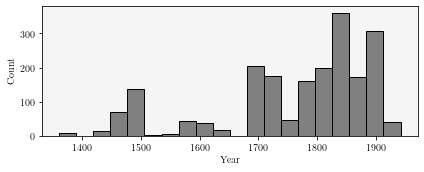

In [11]:
fig, ax = plt.subplots(figsize=(6,2.5))

ax.hist(df["display_year"].values, bins=20, color="gray", lw=1., edgecolor="k")

ax.set_xlabel("Year")
ax.set_ylabel("Count")
plt.tight_layout()
plt.savefig("img/piece_dist.pdf")
plt.show()

## Pitch class counts

In [12]:
counts = df.loc[:, "Fbb":"B##"]
counts.index = df.display_year
counts = counts.sort_index()
counts.head()

,Fbb,Cbb,Gbb,Dbb,Abb,Ebb,Bbb,Fb,Cb,Gb,...,A#,E#,B#,F##,C##,G##,D##,A##,E##,B##
display_year,,,,,,,,,,,,,,,,,,,,,
1361.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1361.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1361.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1361.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1370.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
counts.columns = counts.columns.str.replace("#", r"$\sharp$").str.replace("b", r"$\flat$")

In [14]:
freqs = counts.div(counts.sum(axis=1), axis=0)

In [15]:
tpcs = counts.columns

In [16]:
year_freqs = counts.div(counts.sum(axis=1), axis=0)
year_freqs = year_freqs.groupby("display_year").sum()#.reindex(all_years)

In [17]:
normalized_year_freqs = year_freqs.div(year_freqs.sum(axis=1), axis=0)
normalized_year_freqs.head()

,F$\flat$$\flat$,C$\flat$$\flat$,G$\flat$$\flat$,D$\flat$$\flat$,A$\flat$$\flat$,E$\flat$$\flat$,B$\flat$$\flat$,F$\flat$,C$\flat$,G$\flat$,...,A$\sharp$,E$\sharp$,B$\sharp$,F$\sharp$$\sharp$,C$\sharp$$\sharp$,G$\sharp$$\sharp$,D$\sharp$$\sharp$,A$\sharp$$\sharp$,E$\sharp$$\sharp$,B$\sharp$$\sharp$
display_year,,,,,,,,,,,,,,,,,,,,,
1361.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1370.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1377.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1436.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1440.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
pal = sns.color_palette("seismic", 35)

# export for LaTeX
l = [ "\definecolor{" + f"{pc.replace('#', 's')}" + "}{HTML}" + "{" f"{c[1:]}" + "}" for c, pc in zip(list(pal.as_hex()), counts.columns) ][11:24] # only for Ab - G#
s = "\n".join(l)
with open("colors.tex", "w") as tex_file:
    tex_file.write(s)

pal

[(0.0, 0.0, 0.3768627450980392),
 (0.0, 0.0, 0.45372549019607844),
 (0.0, 0.0, 0.5305882352941176),
 (0.0, 0.0, 0.6074509803921568),
 (0.0, 0.0, 0.6843137254901961),
 (0.0, 0.0, 0.7611764705882352),
 (0.0, 0.0, 0.8380392156862744),
 (0.0, 0.0, 0.9149019607843136),
 (0.00392156862745098, 0.00392156862745098, 1.0),
 (0.11372549019607843, 0.11372549019607843, 1.0),
 (0.2235294117647059, 0.2235294117647059, 1.0),
 (0.3333333333333333, 0.3333333333333333, 1.0),
 (0.44313725490196076, 0.44313725490196076, 1.0),
 (0.5529411764705883, 0.5529411764705883, 1.0),
 (0.6627450980392154, 0.6627450980392154, 1.0),
 (0.7725490196078432, 0.7725490196078432, 1.0),
 (0.8823529411764706, 0.8823529411764706, 1.0),
 (1.0, 0.9921568627450981, 0.9921568627450981),
 (1.0, 0.8823529411764706, 0.8823529411764706),
 (1.0, 0.7725490196078432, 0.7725490196078432),
 (1.0, 0.6627450980392157, 0.6627450980392157),
 (1.0, 0.5529411764705883, 0.5529411764705883),
 (1.0, 0.44313725490196076, 0.44313725490196076),
 (1.0, 0.33333333333333337, 0.33333333333333337),
 (1.0, 0.22352941176470587, 0.22352941176470587),
 (1.0, 0.11372549019607847, 0.11372549019607847),
 (0.9941176470588236, 0.0, 0.0),
 (0.9392156862745098, 0.0, 0.0),
 (0.884313725490196, 0.0, 0.0),
 (0.8294117647058823, 0.0, 0.0),
 (0.7745098039215687, 0.0, 0.0),
 (0.7196078431372549, 0.0, 0.0),
 (0.6647058823529413, 0.0, 0.0),
 (0.6098039215686275, 0.0, 0.0),
 (0.5549019607843138, 0.0, 0.0)]

## Line of fifths plot

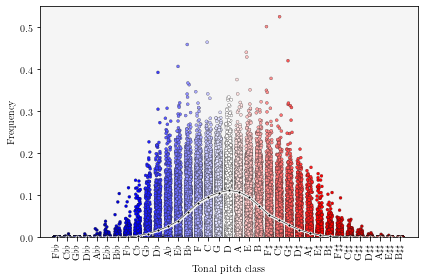

In [19]:
fig, ax = plt.subplots(figsize=(6,4))

sns.stripplot(
    data=freqs.melt(), 
    x="variable", 
    y="value", 
    ax=ax,
    palette="seismic",
    jitter=.27,
    linewidth=.25,
    alpha=1,
    zorder=1,
    s=3
)

# error bands
sns.lineplot(
    data=freqs.melt(), 
    x="variable",
    y="value",
    ax=ax, 
    color=ax.get_facecolor(),
    err_kws={"alpha":1},
    n_boot=10_000,
    zorder=2,
    ci=95
)
# mean
sns.lineplot(
    data=freqs.melt(), 
    x="variable",
    y="value",
    marker=".",
    ax=ax, 
    color="black",
    linewidth=.5,
    err_kws={"alpha":0},
    zorder=3
)

tpc_labels = [ l.get_text().replace("b", r"$\flat$").replace("#", r"$\sharp$") for l in ax.get_xticklabels() ]
ax.set_xticklabels(tpc_labels)
ax.set_ylim(0,0.55)
ax.set_xlabel("Tonal pitch class")
ax.set_ylabel("Frequency")

plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("img/lof_new.pdf")
plt.show()

## PCA

In [40]:
pca = PCA()
X = freqs.fillna(0).values
X_ = pca.fit_transform(X)

In [41]:
piece_colors = [pal[freqs.columns.get_loc(c)] for c in freqs.idxmax(axis=1).values]

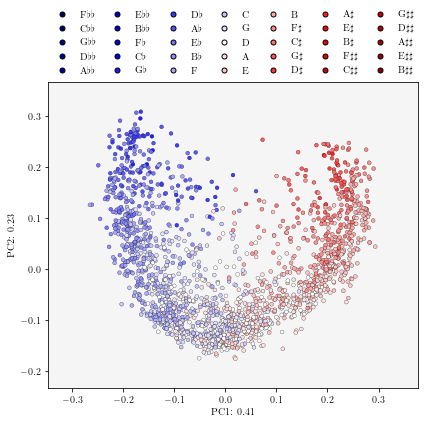

In [42]:
legend_kws = {
    'bbox_to_anchor':(0, 1.01, 1., .102),
    'ncol':7, #int(np.ceil(len(df.columns)/5)), 
    'loc':3,
    'mode':"expand", 
    "framealpha":0,
    "fancybox":False,
    'borderaxespad':0}

legend_elements = [ Line2D([0], [0], 
                           markerfacecolor=pal[i], 
                           marker=".", 
                           color="k", 
                           markersize=10,
                           lw=.5,
                           linestyle="None"
                          ) for i in range(35) ]

fig, ax = plt.subplots(figsize=(6,6))
ax.axis("equal")

ax.scatter(X_[:,0], X_[:,1], 
           s=15, 
           c=piece_colors, 
           edgecolor="k",
           linewidth=.25,
           alpha=1.)

ax.set_xlabel(f"PC1: {round(pca.explained_variance_ratio_[0], 2)}")
ax.set_ylabel(f"PC2: {round(pca.explained_variance_ratio_[1], 2)}")

labels = [ l.replace("b", "$\\flat$").replace("#", "$\\sharp$") for l in freqs.columns]
plt.legend(legend_elements, labels, **legend_kws)


plt.tight_layout()
plt.savefig("img/dim_reduct.pdf")
plt.show()

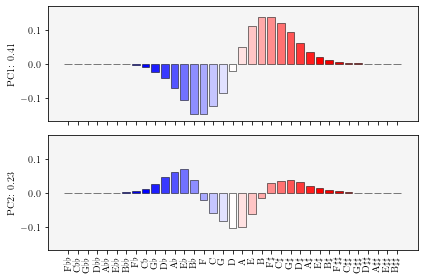

In [43]:
fig, axes = plt.subplots(2,1, figsize=(6,4), sharex=True)

for i in range(2):
    axes[i].bar(
        np.arange(35), 
        pca.components_[i] * pca.explained_variance_ratio_[i], 
        color=pal, 
        edgecolor="k", 
        lw=0.5
    )
    
    axes[i].set_ylabel(f"PC{i+1}: {round(pca.explained_variance_ratio_[i],2)}")
    axes[i].set_ylim(-.17,.17)
plt.xticks(np.arange(35), labels, rotation=90)
plt.margins(0,0)
plt.tight_layout()
plt.savefig("img/pca_lof_PCs.pdf");

## Fifth range

In [24]:
def lof_range(piece):
    l = [i for i, v in enumerate(piece) if v!=0]
    return max(l) - min(l)

In [25]:
fifths_range = df.sort_values(by="display_year")[["display_year"]].copy()
fifths_range["range"] = counts.apply(lof_range, axis=1).values
df["fr"] = fifths_range["range"]

fifths_range.head()

,display_year,range
931,1361.0,9
1160,1361.0,10
756,1361.0,7
1543,1361.0,10
736,1370.0,9


In [26]:
fr_min = fifths_range["range"].min()
fr_max = fifths_range["range"].max()

fr_min, fr_max

(5, 31)

In [27]:
extrema = df.index.isin([331, 830, 1581, 1040])

In [28]:
# Jitter from https://stackoverflow.com/questions/8671808/matplotlib-avoiding-overlapping-datapoints-in-a-scatter-dot-beeswarm-plot

def rand_jitter(arr, jitter):
    stdev = jitter * (max(arr) - min(arr))
    return arr + np.random.randn(len(arr)) * stdev

def jitter(x, y, s=20, c='b', marker='o', jitter=0, cmap=None, norm=None, vmin=None, vmax=None, alpha=None, linewidths=None, verts=None, hold=None, **kwargs):
    return plt.scatter(
        rand_jitter(x, jitter), 
        rand_jitter(y, jitter), 
        s=s, 
        c=c, 
        marker=marker, 
        cmap=cmap, 
        norm=norm, 
        vmin=vmin, 
        vmax=vmax, 
        alpha=alpha, 
        linewidths=linewidths, 
        **kwargs
    )

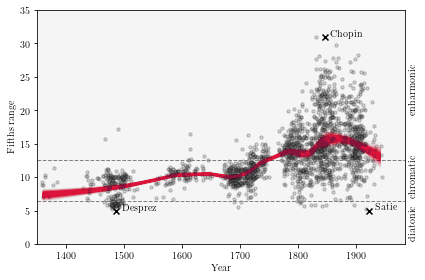

In [29]:
fig, ax = plt.subplots()

jitter(
    fifths_range[~extrema]["display_year"], 
    fifths_range[~extrema]["range"], 
    alpha=.25, 
    s=10,
    c="grey",
    marker="o",
    edgecolor="k",
    jitter=0.01
)

# min/max composers

for x, y, s in zip([1486, 1923, 1846], [5, 5, 31], ["Desprez", "Satie", "Chopin"]):
    ax.scatter(x,y, marker="x", color="black")
    ax.text(x+10,y,s)
    
## REGIONS

ax.axhline(6.5, c="gray", linestyle="--", lw=1) # dia / chrom.
ax.axhline(12.5, c="gray", linestyle="--", lw=1) # chr. / enh.

text_kws = {
    "rotation" : 90,
    "horizontalalignment" : "center",
    "verticalalignment" : "center"
}

ax.text(2000, 3, "diatonic", **text_kws)
ax.text(2000, 10, "chromatic", **text_kws)
ax.text(2000, 23, "enharmonic", **text_kws)

# bootstrap
B = 1000
for _ in range(B):
    sample = fifths_range.sample(counts.shape[0], replace=True)
    
    x = sample["display_year"]
    y = sample["range"]
    l = lowess(y,x, frac=.2)

    ax.plot(l[:,0], l[:,1], c="crimson", alpha=.01)

plt.ylabel("Fifths range")
plt.xlabel("Year")
plt.xlim(1350,1985)
plt.ylim(0,35)

plt.tight_layout()
plt.savefig("img/fifth_range.pdf")
plt.show()

## Pitch Class evolution

In [30]:
periods = [ (y, y + 99) for y in np.arange(1300,2000,100) ][1:]

In [31]:
year_freqs = counts.div(counts.sum(axis=1), axis=0)
year_freqs = year_freqs.groupby("display_year").sum()#.reindex(all_years)

In [32]:
normalized_year_freqs = year_freqs.div(year_freqs.sum(axis=1), axis=0)
normalized_year_freqs.head()

,F$\flat$$\flat$,C$\flat$$\flat$,G$\flat$$\flat$,D$\flat$$\flat$,A$\flat$$\flat$,E$\flat$$\flat$,B$\flat$$\flat$,F$\flat$,C$\flat$,G$\flat$,...,A$\sharp$,E$\sharp$,B$\sharp$,F$\sharp$$\sharp$,C$\sharp$$\sharp$,G$\sharp$$\sharp$,D$\sharp$$\sharp$,A$\sharp$$\sharp$,E$\sharp$$\sharp$,B$\sharp$$\sharp$
display_year,,,,,,,,,,,,,,,,,,,,,
1361.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1370.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1377.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1436.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1440.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


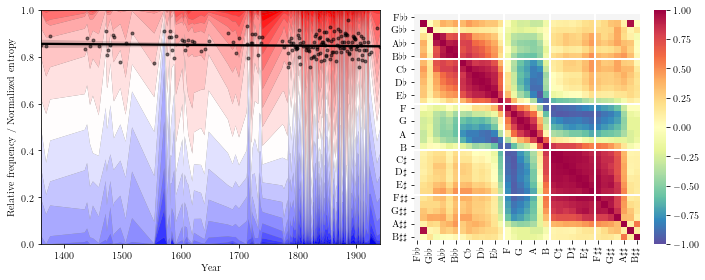

In [33]:
combinedplot(normalized_year_freqs, savepath="img/all_piece_freqs.pdf", entropy=True)

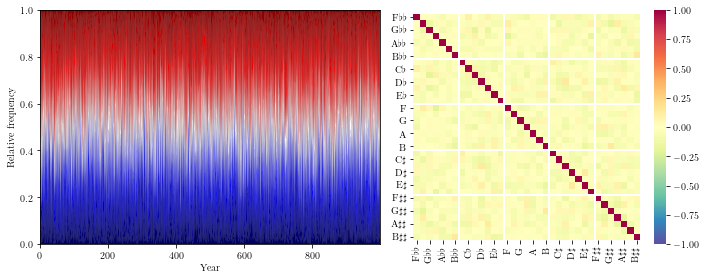

In [34]:
random_samples = pd.DataFrame(np.random.dirichlet(np.ones(35), size=1_000), columns=tpcs)
combinedplot(random_samples, savepath="img/random_piece_freqs.pdf", entropy=False)

In [35]:
pca = PCA()

X = normalized_year_freqs.corr().fillna(0).values
X_ = pca.fit_transform(X)

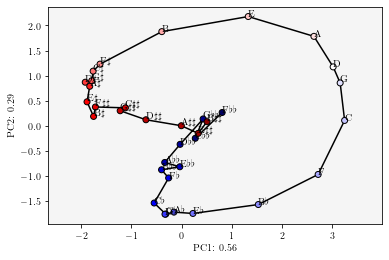

In [36]:
fig, ax = plt.subplots()

ax.axis("equal")
ax.plot(X_[:,0], X_[:,1], "k", zorder=-5)
ax.scatter(X_[:,0], X_[:,1], color=pal, edgecolor="k", lw=1)


for x, y, l in zip(X_[:,0], X_[:,1], tpcs):
    ax.text(x,y,l)
    
var = pca.explained_variance_ratio_

ax.set_xlabel(f"PC1: {round(var[0], 2)}")
ax.set_ylabel(f"PC2: {round(var[1], 2)}")
plt.savefig("img/tpc_coevolution_pca2.pdf")
plt.show()

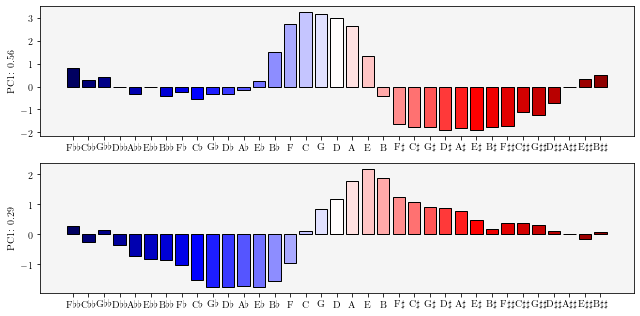

In [37]:
fig, axes = plt.subplots(var[:2].shape[0], 1, figsize=(9,4.5), sharex=False)

for i in range(var[:2].shape[0]):
    axes[i].set_facecolor("whitesmoke")
    axes[i].bar(np.arange(35), X_[:,i], color=pal, lw=1, edgecolor="k")
    axes[i].set_xticks(np.arange(35))
    axes[i].set_xticklabels(tpcs)
    axes[i].set_ylabel(f"PC1: {round(var[i], 2)}")

plt.tight_layout()
plt.savefig("img/tpcs_coevolution_principal_components.pdf")
plt.show()

## Coevolution per period

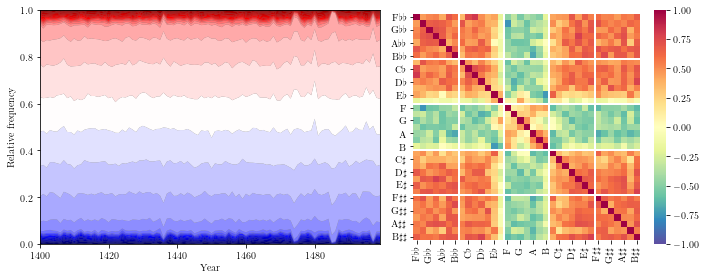

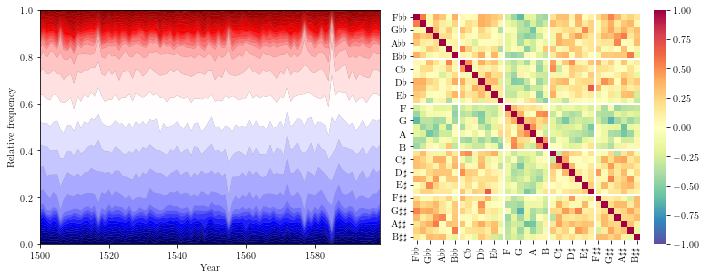

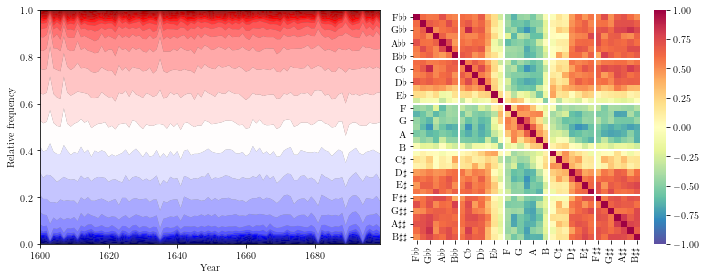

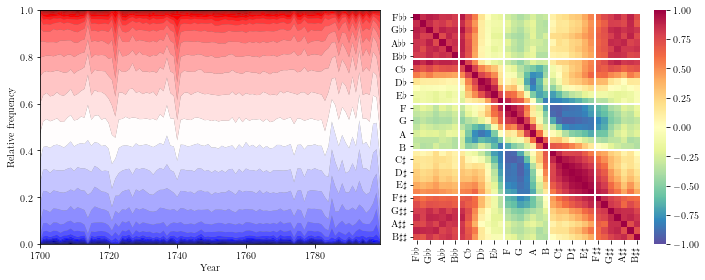

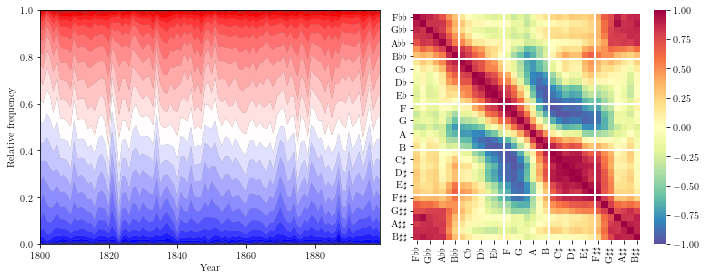

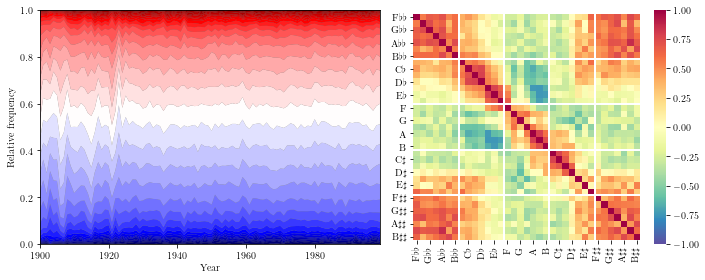

In [48]:
N = 1000

for period in periods:
    # select data in centuries range
    df = counts.loc[ (counts.index >= period[0]) & (counts.index <= period[1])]
    
    # normalize freqs
    df = df.div(df.sum(axis=1), axis=0)
    
    # prior for dirichlet 
    alpha = np.ones(35)
    
    # update with pieces within period
    alpha += df.sum(axis=0)
    
    # draw samples and years
    samples = np.random.dirichlet(alpha, size=N)
    years = np.random.randint(low=period[0], high=period[1]+1, size=N)
    
    # aggregate samples per year    
    samples = pd.DataFrame(samples, columns=tpcs)
    samples["year"] = years
    samples = samples.groupby("year").sum()
    
    # add original pieces
    for i, row in df.iterrows():
        samples.loc[round(i),:] += row
    
    # renormalize
    samples = samples.div(samples.sum(axis=1), axis=0)
    
    combinedplot(samples, savepath=f"img/piece_freqs_{period[0]}.pdf")